In [1]:
import glob
import json
import os
import random as rnd
import shutil

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow import keras
from tqdm import tqdm
import annoy
from src.test_utils import TestGenerator
import time
InteractiveShell.ast_node_interactivity = "all"

In [9]:
nn.BatchNorm1d(512)(torch.tensor(np.random.random([32,512,60]), dtype=torch.float)).shape

torch.Size([32, 512, 60])

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 64
        self.img_size = (512, 60)
        self.crop = self.img_size < (512, 81)
        self.n_chanels = 1
        self.n_folds = 6
        self.fold = 2
        self.norm = False
        self.emb_len = 1024
        self.kernel_size = (5, 2)
        self.act_fn = "relu"
        self.n_epochs = 60
        self.input_shape = (*self.img_size, self.n_chanels)

In [3]:
cfg = CFG()

In [4]:
cfg.input_shape

(512, 60, 1)

In [5]:
root_dir = "/app/_data/artist_data/"
mod_dir = "/app/_data/artist_data/models/test_arch/tripl_5/"

In [6]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))
train = train[train["artistid_count"] != 1].reset_index(drop=True)

## train_val_split

In [7]:
gkf = StratifiedGroupKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

In [8]:
train_df = train[train["fold"] != cfg.fold].reset_index(drop=True)
val_df = train[train["fold"] == cfg.fold].reset_index(drop=True)

## DataGenerator

In [9]:
train_gen = TestGenerator(
    data=train,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
)

In [10]:
imgs = train_gen.__getitem__(0)

In [11]:
imgs.shape

(64, 512, 60, 1)

## torch

In [12]:
timgs = torch.tensor(imgs[:, :, :, 0], dtype=torch.float)

In [13]:
class BasicNet(nn.Module):
    def __init__(
        self, img_h=512, img_w=60, output_features_size=512, emb_len=1024, kernel_size=3
    ):
        super().__init__()
        self.output_features_size = output_features_size
        self.emb_len = emb_len
        self.conv_1 = nn.Conv1d(
            img_h, output_features_size, kernel_size=kernel_size, padding=1
        )
        self.conv_2 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1 = nn.MaxPool1d(2)
        self.conv_3 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.conv_4 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_2 = nn.MaxPool1d(2)
        self.conv_5 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.conv_6 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_3 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(
            output_features_size * (img_w // 8), out_features=emb_len, bias=False
        )

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        print(x.shape)
        x = F.relu(self.conv_2(x))
        print(x.shape)
        x = self.mp_1(x)
        print(x.shape)
        x = F.relu(self.conv_3(x))
        print(x.shape)
        x = F.relu(self.conv_4(x))
        print(x.shape)
        x = self.mp_2(x)
        print(x.shape)
        x = F.relu(self.conv_5(x))
        print(x.shape)
        x = F.relu(self.conv_6(x))
        print(x.shape)
        x = self.mp_3(x)
        print(x.shape)
        x = self.flatten(x)
        print(x.shape)
        x = self.dense(x)
        print(x.shape)
        return x

In [14]:
m1 = BasicNet(
    img_h=512, img_w=60, output_features_size=512, emb_len=1024, kernel_size=3
)

In [15]:
p = m1(timgs)

torch.Size([64, 512, 60])
torch.Size([64, 512, 60])
torch.Size([64, 512, 30])
torch.Size([64, 512, 30])
torch.Size([64, 512, 30])
torch.Size([64, 512, 15])
torch.Size([64, 512, 15])
torch.Size([64, 512, 15])
torch.Size([64, 512, 7])
torch.Size([64, 3584])
torch.Size([64, 1024])


In [16]:
m1.output_features_size

512

In [17]:
m1 = BasicNet(img_h=60, img_w=512, output_features_size=60, emb_len=512, kernel_size=3)
p2 = m1(timgs.transpose(2, 1))

torch.Size([64, 60, 512])
torch.Size([64, 60, 512])
torch.Size([64, 60, 256])
torch.Size([64, 60, 256])
torch.Size([64, 60, 256])
torch.Size([64, 60, 128])
torch.Size([64, 60, 128])
torch.Size([64, 60, 128])
torch.Size([64, 60, 64])
torch.Size([64, 3840])
torch.Size([64, 512])


In [139]:
def transform(inputs, output_features_size=1024, kernel_size=3):
    outputs = [inputs]
    outputs.append(
        F.relu(
            nn.Conv1d(512, output_features_size, kernel_size=kernel_size, padding=1)(
                timgs
            )
        )
    )
    outputs.append(
        F.relu(
            nn.Conv1d(
                output_features_size,
                output_features_size,
                kernel_size=kernel_size,
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(nn.MaxPool1d(2)(outputs[-1]))
    outputs.append(
        F.relu(
            nn.Conv1d(
                output_features_size,
                output_features_size * 2,
                kernel_size=kernel_size,
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(
        F.relu(
            nn.Conv1d(
                output_features_size * 2,
                output_features_size * 2,
                kernel_size=kernel_size,
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(nn.MaxPool1d(2)(outputs[-1]))
    outputs.append(
        F.relu(
            nn.Conv1d(
                output_features_size * 2,
                output_features_size * 2,
                kernel_size=outputs[-1].shape[-1],
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(
        F.relu(
            nn.Conv1d(
                output_features_size * 2,
                output_features_size * 2,
                kernel_size=outputs[-1].shape[-1],
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(torch.flatten(outputs[-1], start_dim=1))
    outputs.append(
        nn.Linear(in_features=outputs[-1].shape[-1], out_features=1024, bias=False)(
            outputs[-1]
        )
    )
    for x in outputs:
        print(x.shape)
    return outputs

In [140]:
outputs = transform(inputs=timgs, output_features_size=512, kernel_size=3)

torch.Size([64, 512, 60])
torch.Size([64, 512, 60])
torch.Size([64, 512, 60])
torch.Size([64, 512, 30])
torch.Size([64, 1024, 30])
torch.Size([64, 1024, 30])
torch.Size([64, 1024, 15])
torch.Size([64, 1024, 3])
torch.Size([64, 1024, 3])
torch.Size([64, 3072])
torch.Size([64, 1024])


In [141]:
outputs = transform(
    inputs=timgs.transpose(2, 1), output_features_size=128, kernel_size=3
)

torch.Size([64, 60, 512])
torch.Size([64, 128, 60])
torch.Size([64, 128, 60])
torch.Size([64, 128, 30])
torch.Size([64, 256, 30])
torch.Size([64, 256, 30])
torch.Size([64, 256, 15])
torch.Size([64, 256, 3])
torch.Size([64, 256, 3])
torch.Size([64, 768])
torch.Size([64, 1024])


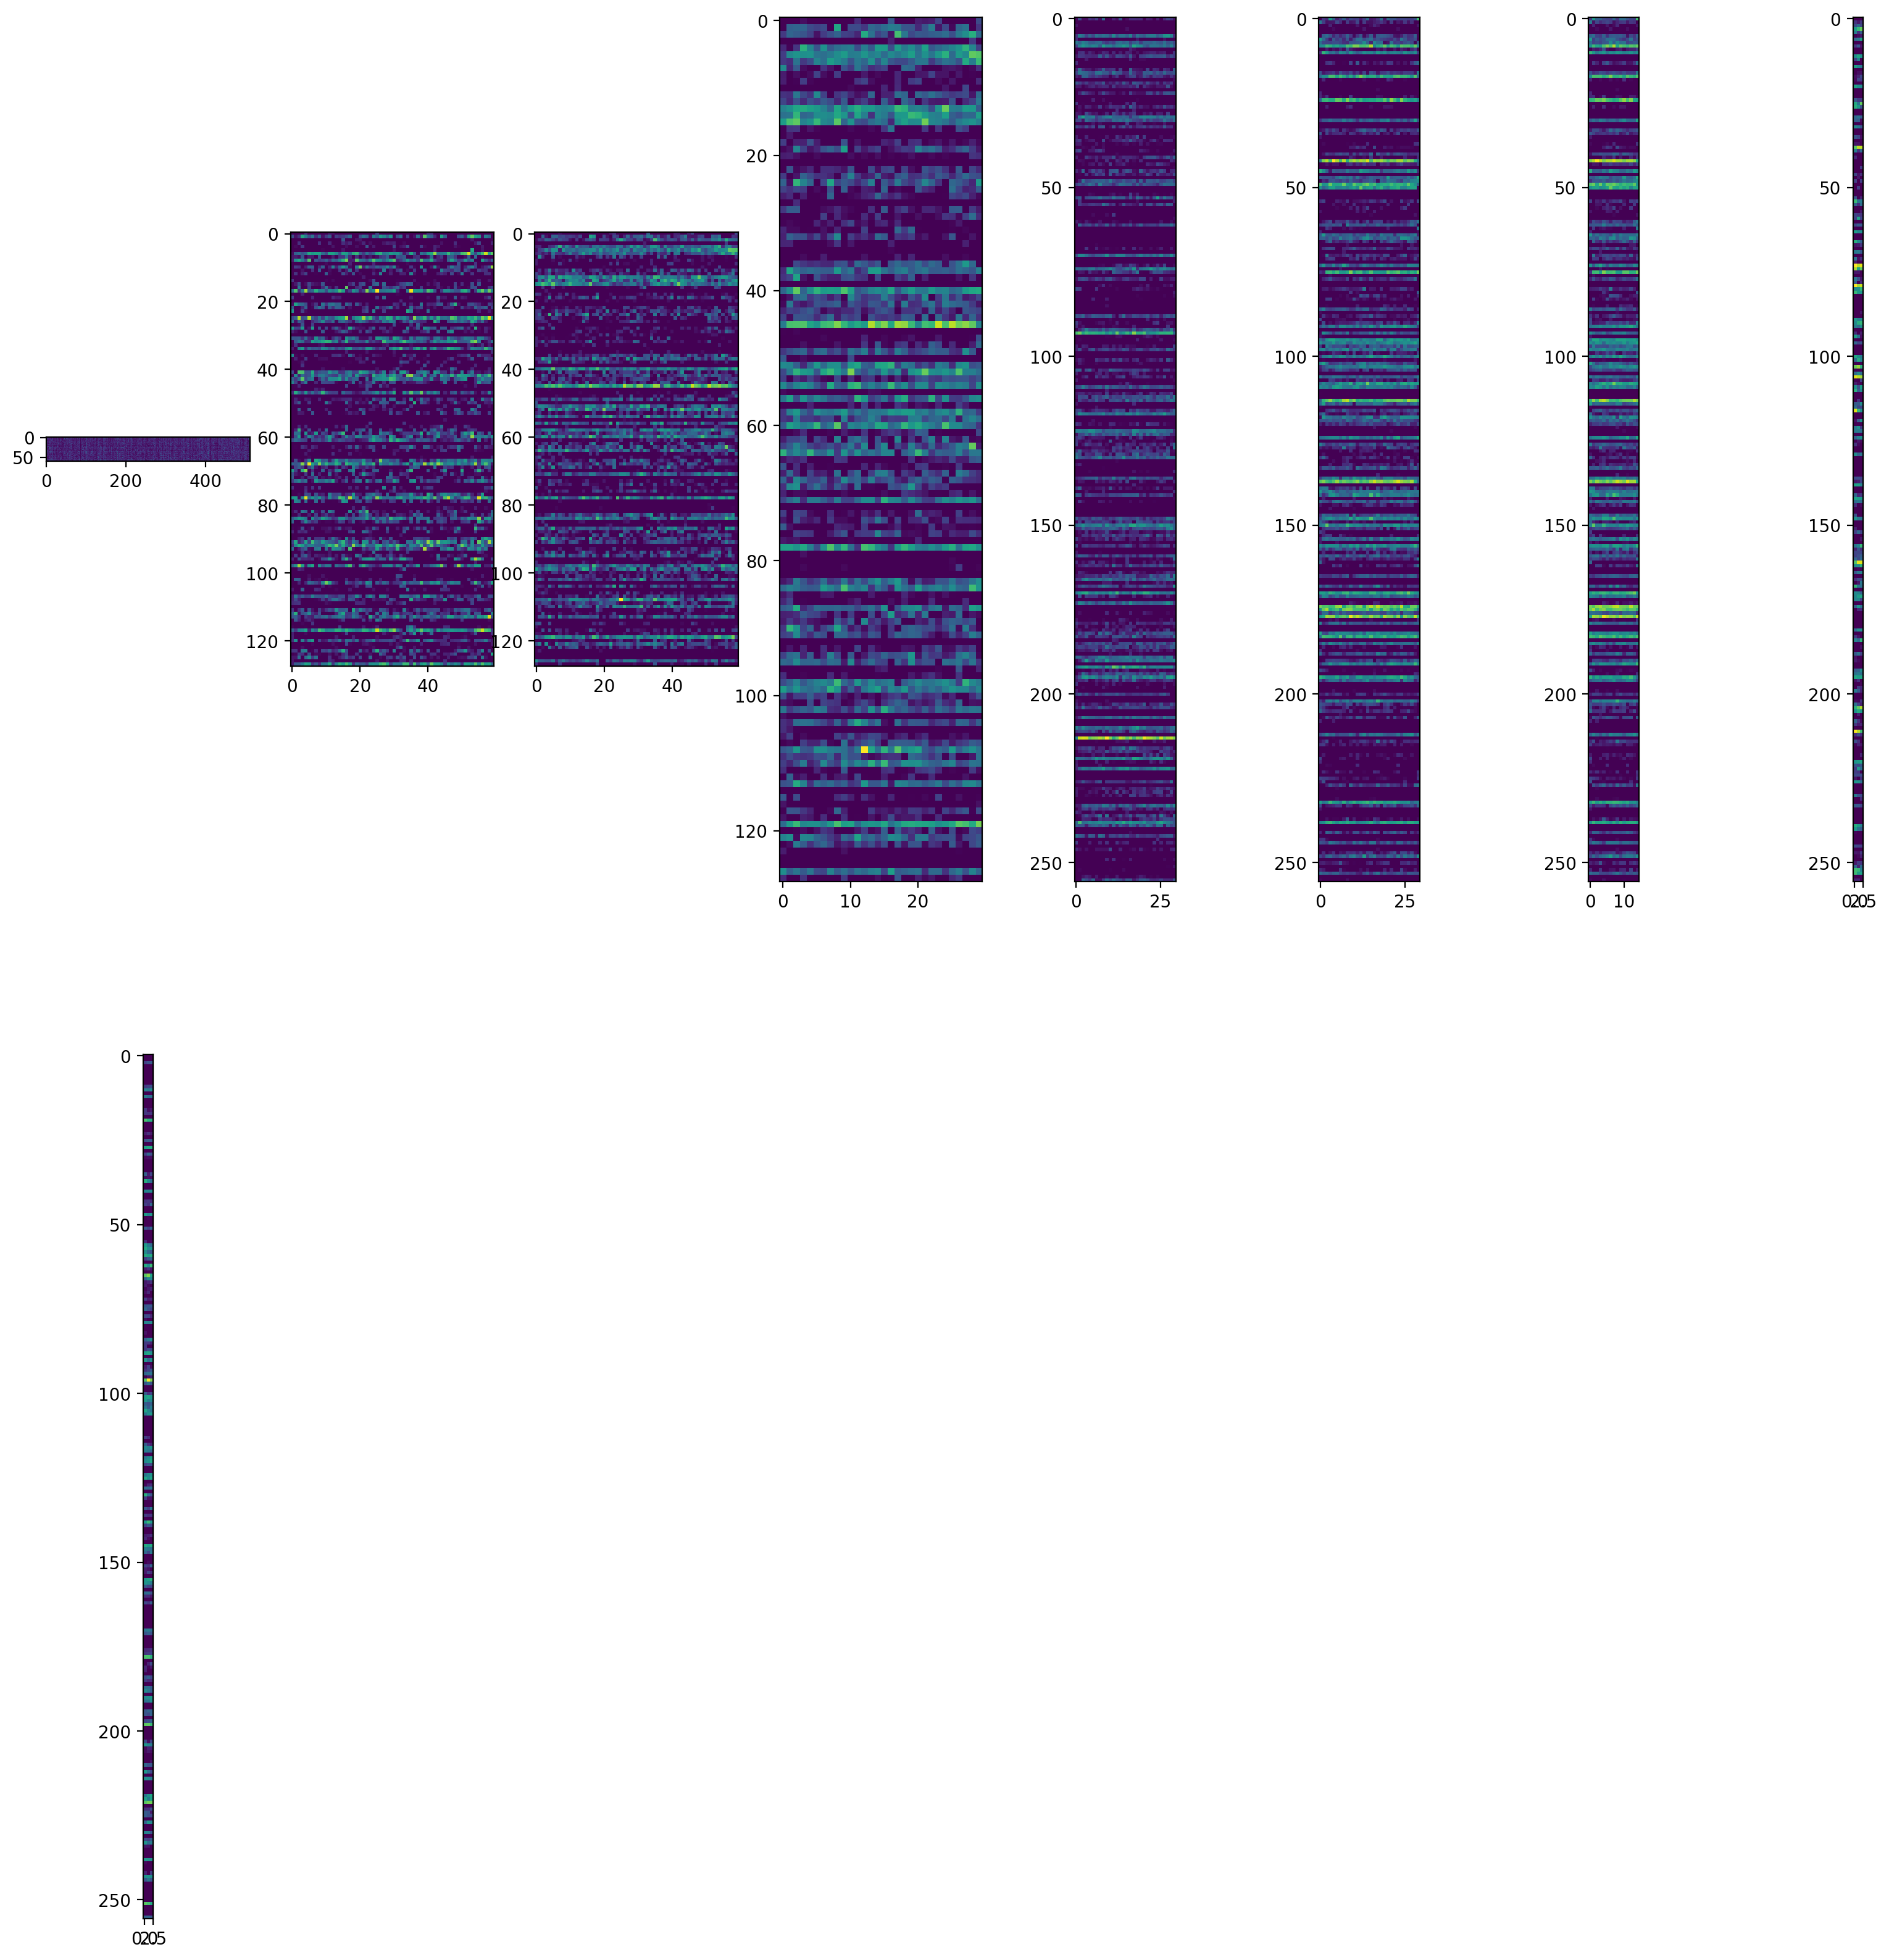

In [142]:
n_plots = len(outputs[:-2])
n_rows = n_plots // 8 + 1
plt.figure(figsize=(20, 10 * n_rows))
for i in range(n_plots):
    plt.subplot(n_rows, 8, i + 1)
    im = outputs[i][2].detach().numpy()
    plt.imshow(im)
plt.show();

torch.Size([64, 512, 60])
torch.Size([64, 512, 58])
torch.Size([64, 512, 56])
torch.Size([64, 512, 28])
torch.Size([64, 1024, 26])
torch.Size([64, 1024, 13])
torch.Size([64, 1024, 3])
torch.Size([64, 1024, 1])


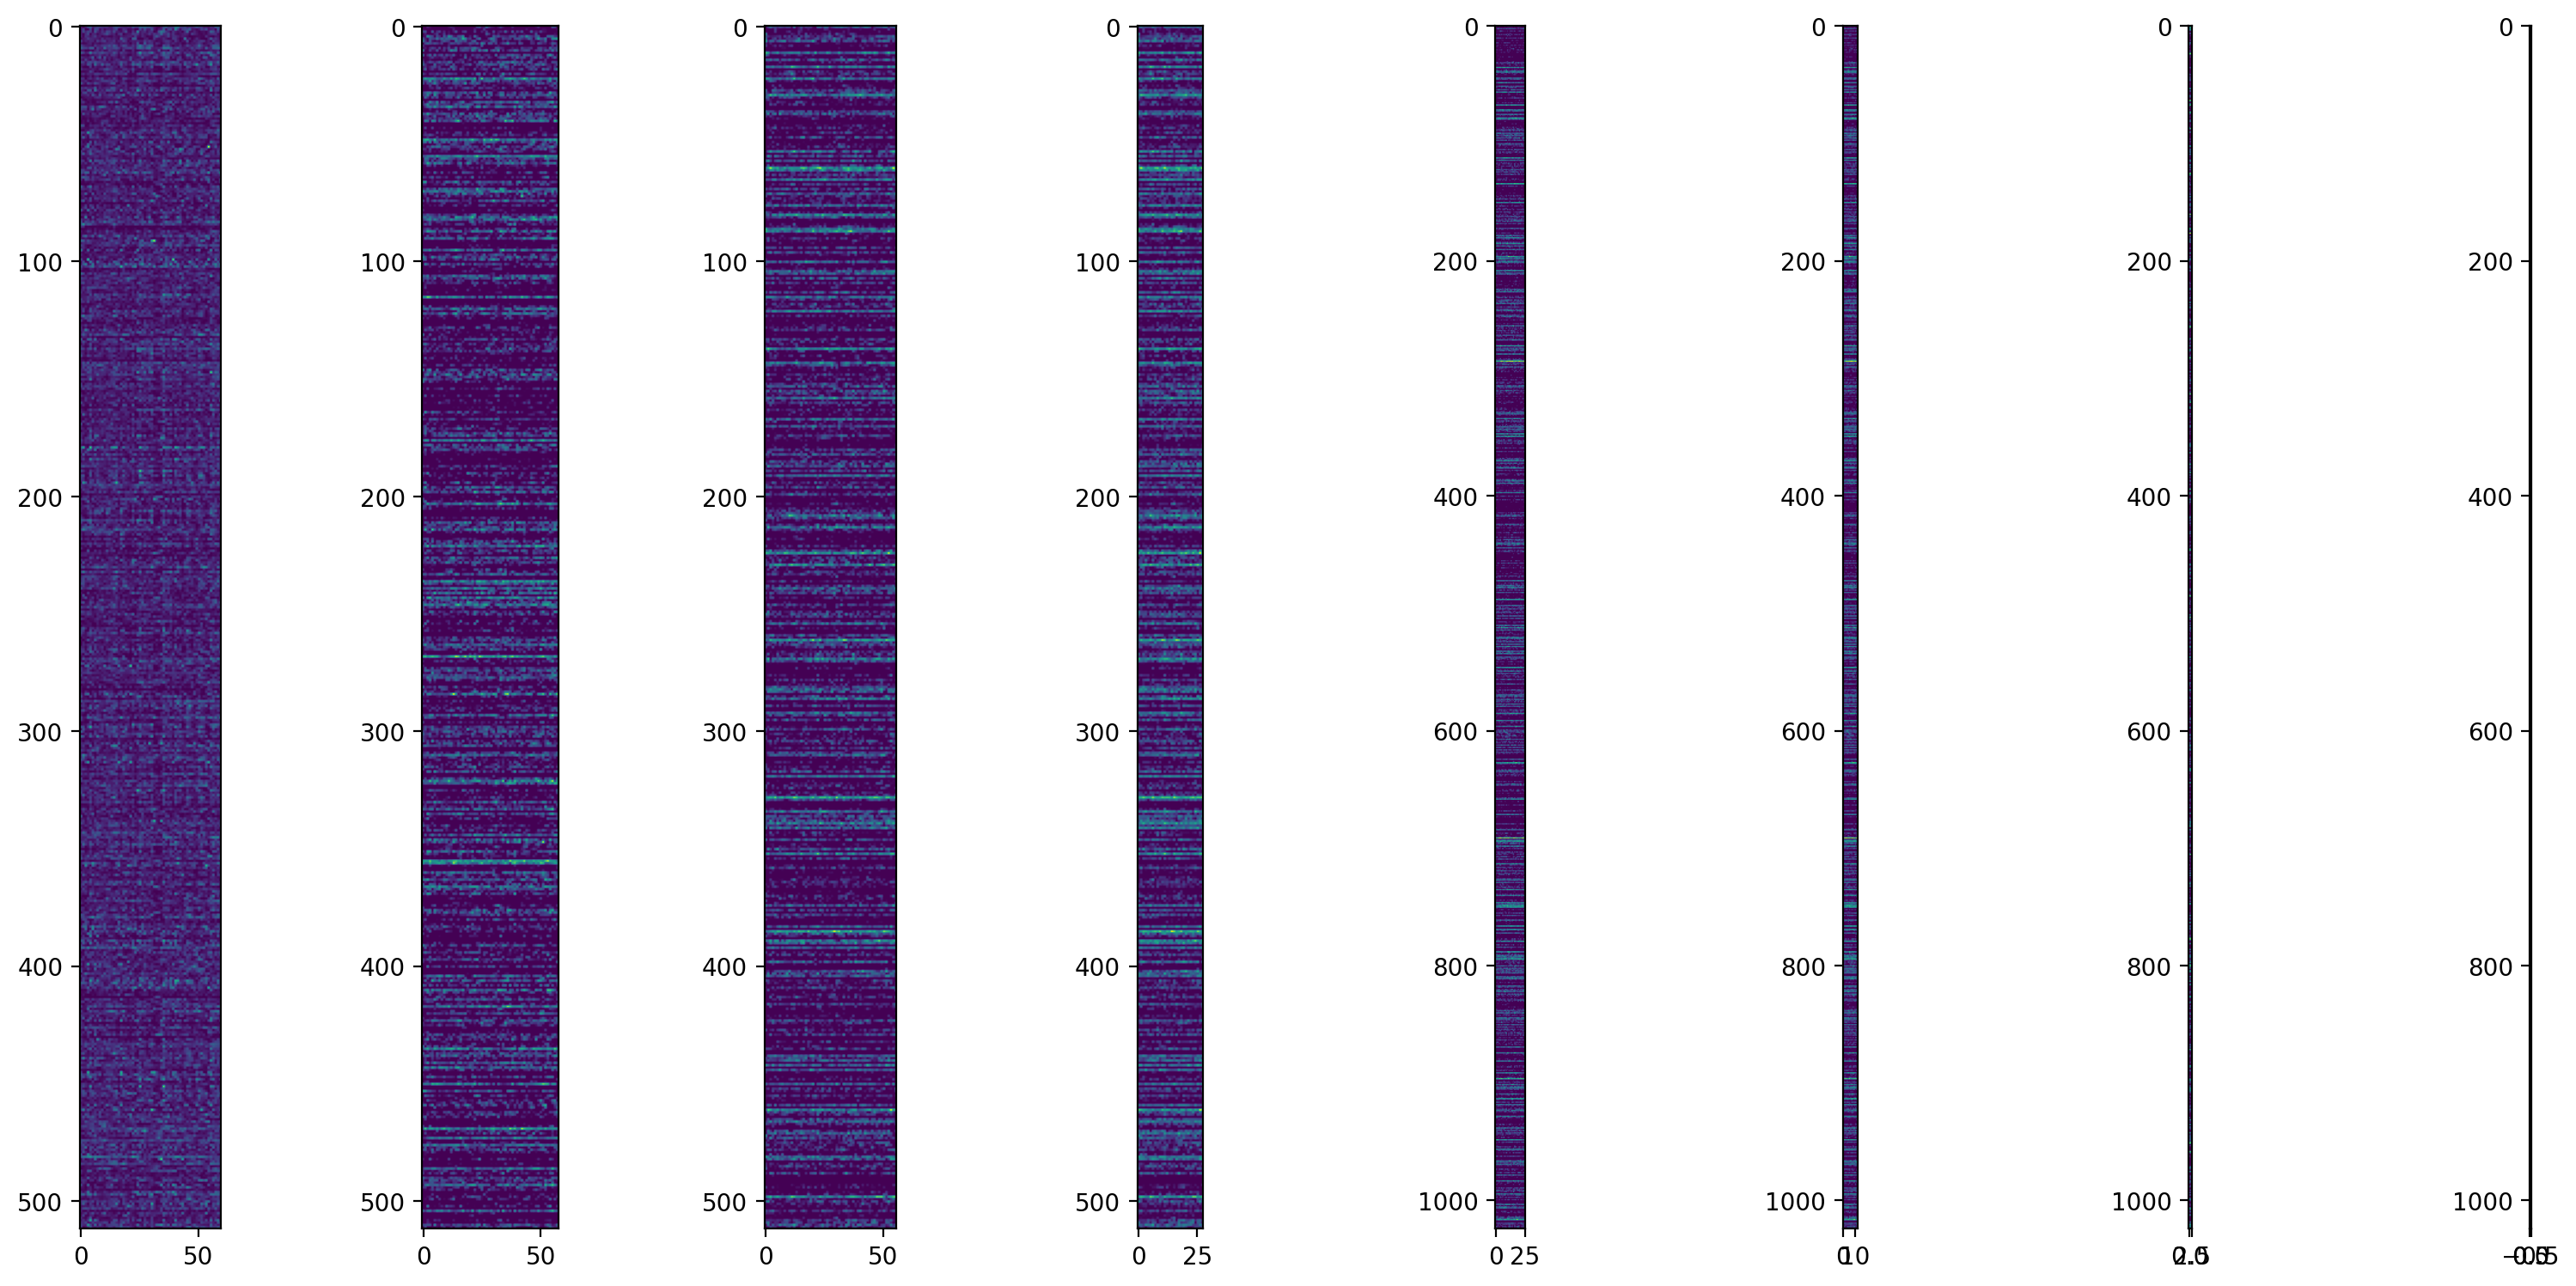

In [101]:
outputs = transform(inputs=timgs, output_features_size=512, kernel_size=5)
n_plots = len(outputs)
n_rows = n_plots // 8 + 1
plt.figure(figsize=(20, 10 * n_rows))
for i in range(n_plots):
    plt.subplot(n_rows, 8, i + 1)
    im = outputs[i][2].detach().numpy()
    plt.imshow(im)
plt.show();

torch.Size([64, 512, 60])
torch.Size([64, 256, 52])
torch.Size([64, 256, 44])
torch.Size([64, 256, 22])
torch.Size([64, 512, 14])
torch.Size([64, 512, 7])
torch.Size([64, 512, 3])
torch.Size([64, 512, 1])


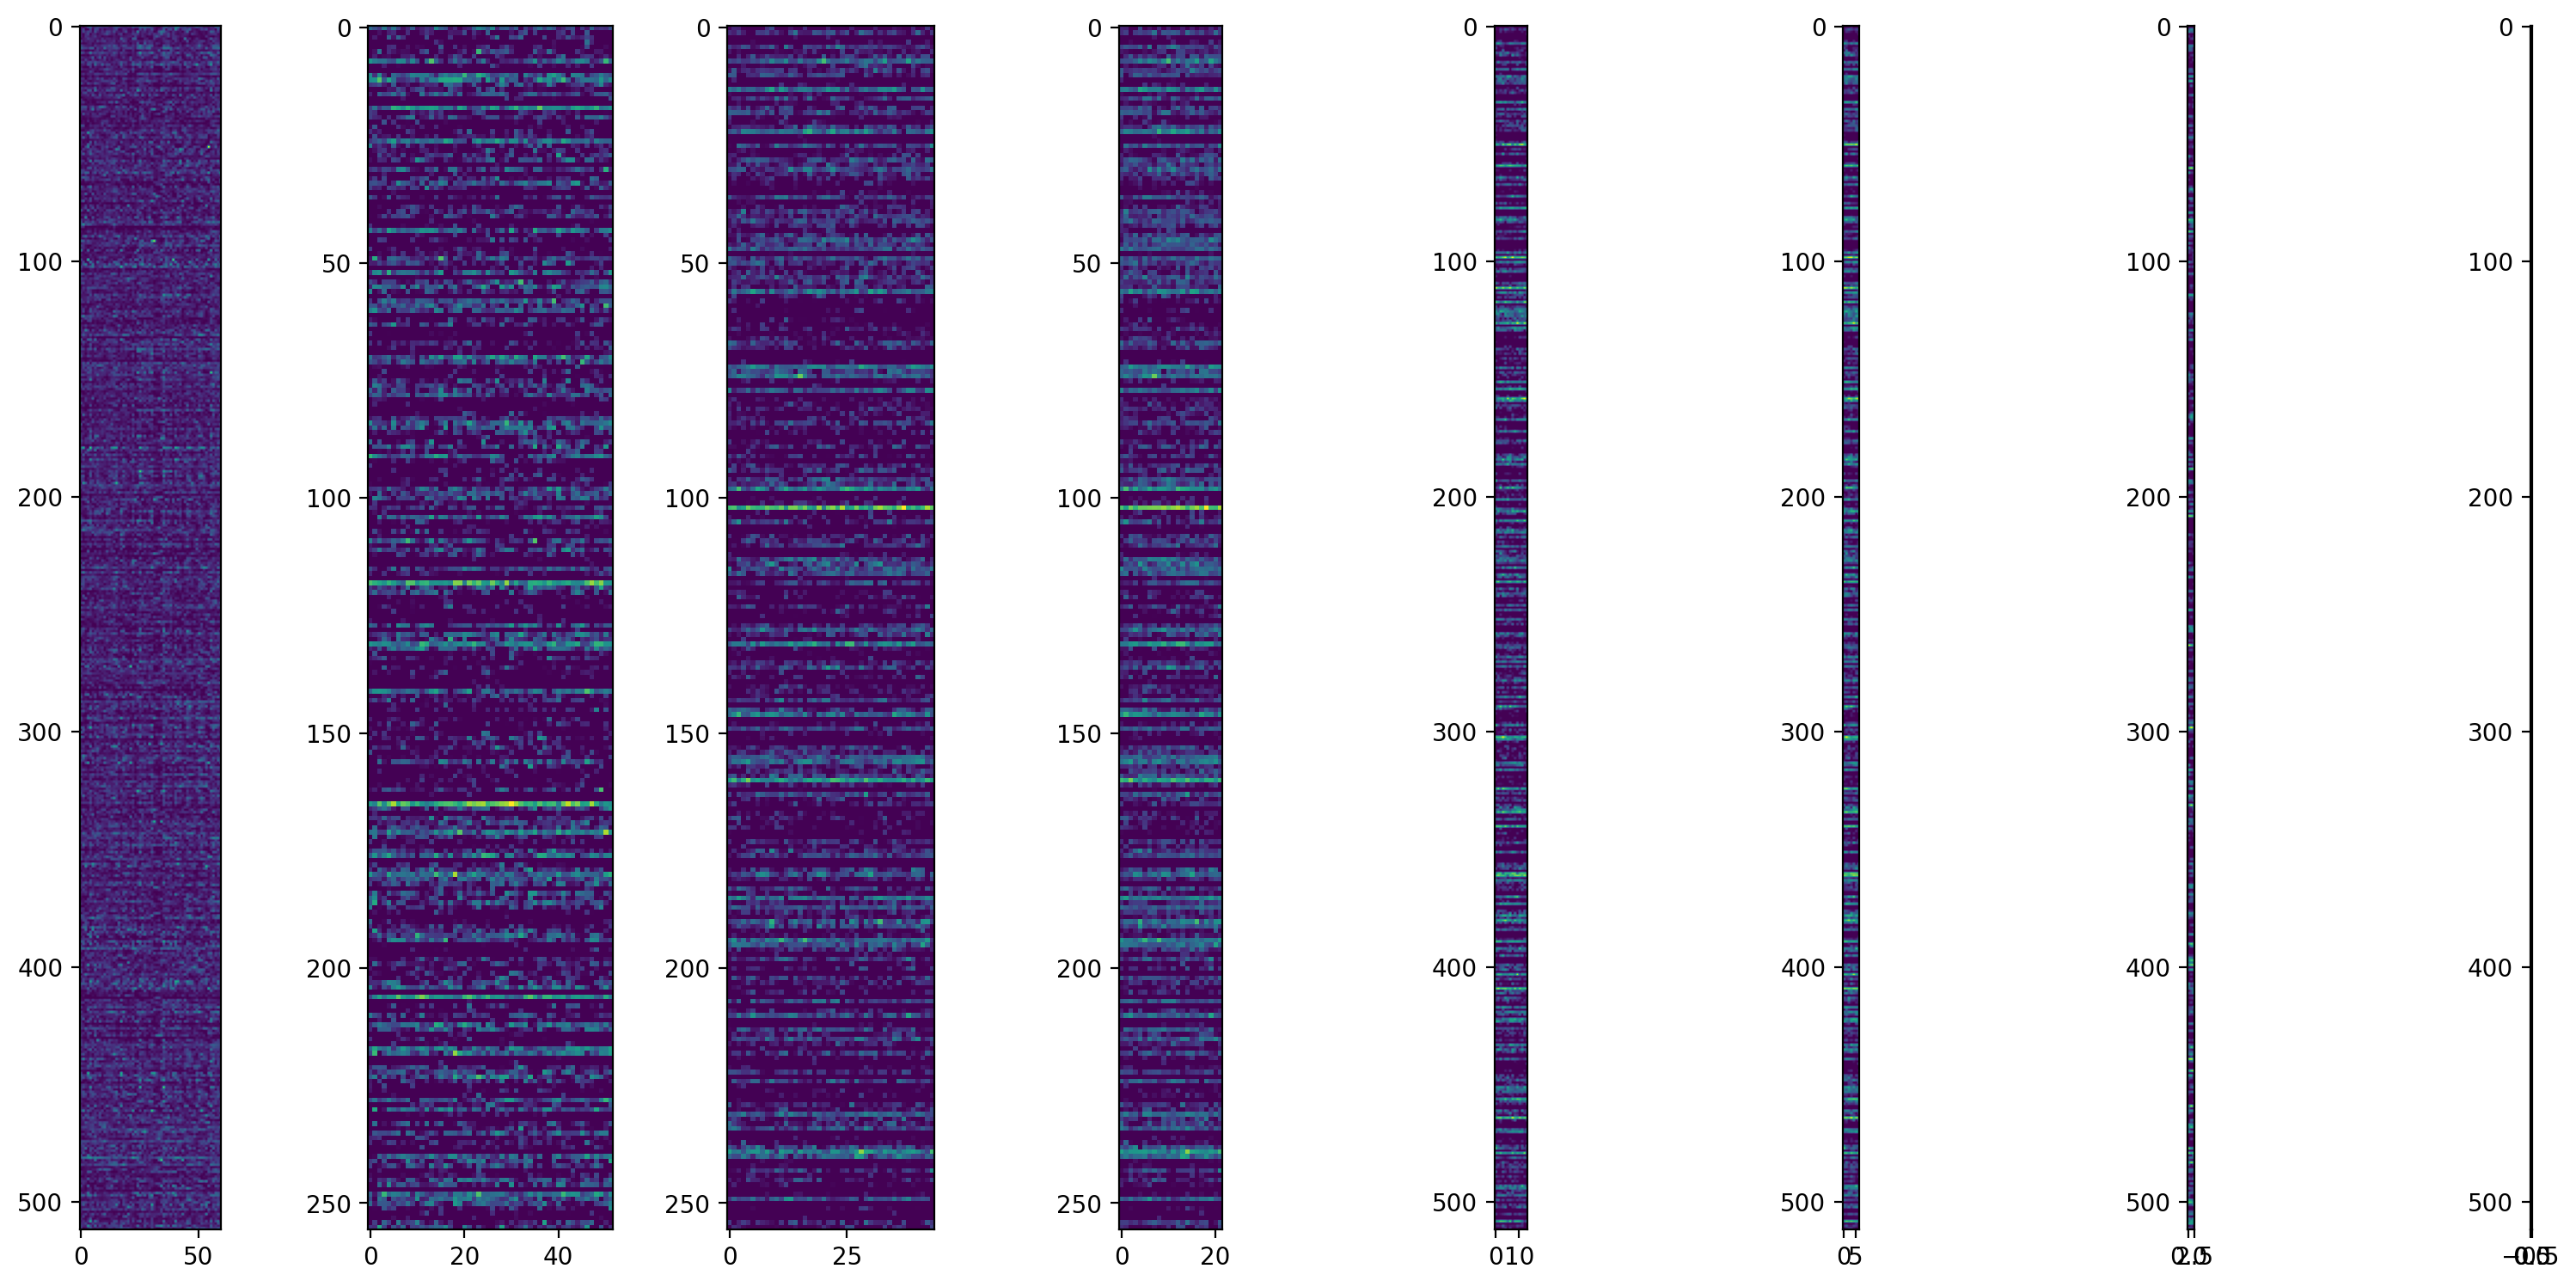

In [102]:
outputs = transform(inputs=timgs, output_features_size=256, kernel_size=11)
n_plots = len(outputs)
n_rows = n_plots // 8 + 1
plt.figure(figsize=(20, 10 * n_rows))
for i in range(n_plots):
    plt.subplot(n_rows, 8, i + 1)
    im = outputs[i][2].detach().numpy()
    plt.imshow(im)
plt.show();

In [41]:
y = nn.TransformerEncoderLayer(d_model=60, nhead=10, dim_feedforward=2048, dropout=0.1)(
    timgs
)
y = nn.TransformerEncoderLayer(d_model=60, nhead=10, dim_feedforward=2048, dropout=0.1)(
    y
)

In [34]:
timgs[0]

tensor([[0.5725, 0.1885, 0.0763,  ..., 1.2771, 0.5823, 0.2738],
        [0.3489, 0.2338, 0.0000,  ..., 0.4254, 0.1510, 0.0000],
        [0.5069, 0.0157, 0.2177,  ..., 0.0052, 0.0783, 0.1690],
        ...,
        [0.4029, 0.1564, 0.0000,  ..., 0.2262, 0.2346, 0.2102],
        [0.0986, 0.1351, 1.3276,  ..., 0.0471, 0.3620, 2.0512],
        [0.2090, 0.2650, 0.1830,  ..., 0.3875, 0.0436, 0.1427]])

In [42]:
y = y.detach().numpy()

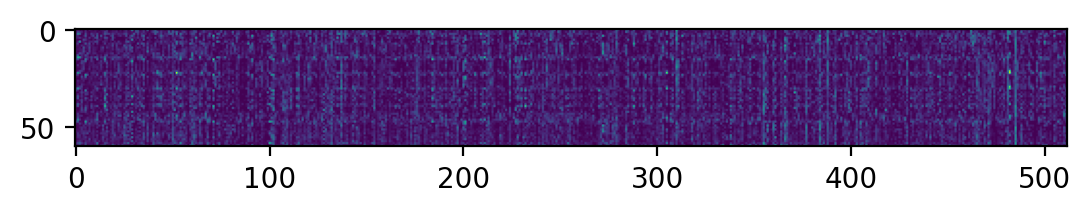

In [50]:
plt.imshow(imgs[1, :, :, 0].transpose(1, 0))

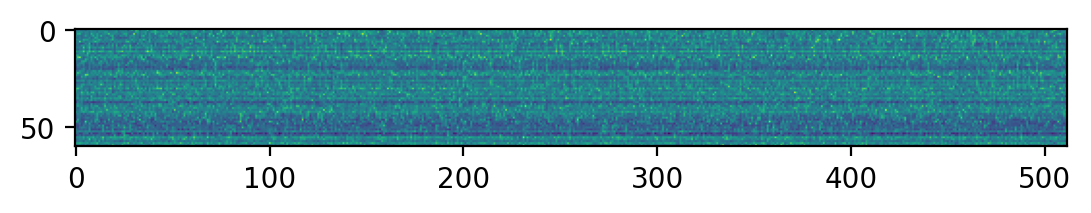

In [51]:
plt.imshow(y[1].transpose(1, 0))

In [74]:
def transform(inputs, output_features_size=1024, kernel_size=3):
    outputs = [inputs]
    outputs.append(F.relu(nn.Conv2d(1, 4, kernel_size=kernel_size, padding=1)(inputs)))
    outputs.append(
        F.relu(
            nn.Conv2d(
                4,
                8,
                kernel_size=kernel_size,
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(nn.MaxPool2d(2)(outputs[-1]))
    outputs.append(
        F.relu(
            nn.Conv2d(
                8,
                16,
                kernel_size=kernel_size,
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(
        F.relu(
            nn.Conv2d(
                16,
                32,
                kernel_size=kernel_size,
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(nn.MaxPool2d(2)(outputs[-1]))
    outputs.append(
        F.relu(
            nn.Conv2d(
                32,
                64,
                kernel_size=outputs[-1].shape[-1],
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(
        F.relu(
            nn.Conv2d(
                64,
                128,
                kernel_size=outputs[-1].shape[-1],
                padding=1,
            )(outputs[-1])
        )
    )
    outputs.append(torch.flatten(outputs[-1], start_dim=1))
    outputs.append(
        nn.Linear(in_features=outputs[-1].shape[-1], out_features=1024, bias=False)(
            outputs[-1]
        )
    )
    for x in outputs:
        print(x.shape)
    return outputs

In [75]:
outputs = transform(inputs=timgs0, output_features_size=256, kernel_size=11)

torch.Size([64, 1, 512, 60])
torch.Size([64, 4, 504, 52])
torch.Size([64, 8, 496, 44])
torch.Size([64, 8, 248, 22])
torch.Size([64, 16, 240, 14])
torch.Size([64, 32, 232, 6])
torch.Size([64, 32, 116, 3])
torch.Size([64, 64, 116, 3])
torch.Size([64, 128, 116, 3])
torch.Size([64, 44544])
torch.Size([64, 1024])


In [63]:
timgs0 = torch.tensor(np.expand_dims(imgs[:, :, :, 0], axis=1), dtype=torch.float)
timgs0.shape

torch.Size([64, 1, 512, 60])

In [73]:
nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)(timgs0).shape

torch.Size([64, 3, 512, 60])

In [ ]:
class BasicNet(nn.Module):
    def __init__(
        self, img_h=512, img_w=60, output_features_size=512, emb_len=1024, kernel_size=3
    ):
        super().__init__()
        self.output_features_size = output_features_size
        self.emb_len = emb_len // 2
        self.conv_1 = nn.Conv1d(
            img_h, output_features_size, kernel_size=kernel_size, padding=1
        )
        self.conv_2 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_1 = nn.MaxPool1d(2)
        self.conv_3 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.conv_4 = nn.Conv1d(
            output_features_size,
            output_features_size,
            kernel_size=kernel_size,
            padding=1,
        )
        self.mp_2 = nn.MaxPool1d(2)
        # self.conv_5 = nn.Conv1d(
        #     output_features_size,
        #     output_features_size,
        #     kernel_size=kernel_size,
        #     padding=1,
        # )
        # self.conv_6 = nn.Conv1d(
        #     output_features_size,
        #     output_features_size,
        #     kernel_size=kernel_size,
        #     padding=1,
        # )
        # self.mp_3 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(
            output_features_size * (img_w // 4), out_features=emb_len, bias=False
        )
        self.dense2 = nn.Linear(emb_len, out_features=emb_len // 2, bias=False)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = self.mp_2(x)
        # x = F.relu(self.conv_5(x))
        # x = F.relu(self.conv_6(x))
        # x = self.mp_3(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dense2(x)
        return x

In [95]:
from torchvision.models import swin_b

In [96]:
swin = swin_b()

In [192]:
a = torch.zeros((30,50))
x = torch.unsqueeze(a, 0)
x = torch.cat([x, x, x], axis=0)
x.shape

torch.Size([3, 30, 50])

In [97]:
simgs = torch.cat([timgs0, timgs0, timgs0], axis=1)
simgs.shape

torch.Size([64, 3, 512, 60])

In [98]:
im = swin(simgs).detach().numpy()
# plt.imshow(im)

In [99]:
im.shape

(64, 1000)

In [100]:
from torchvision.transforms import Normalize

In [101]:
norm = Normalize(mean=0.405778, std=0.033398)

In [102]:
i = norm(simgs)

In [107]:
i[0, 0].mean()

tensor(0.2765)

In [108]:
simgs[0, 0].mean()

tensor(0.4150)

In [109]:
from torchvision.transforms.functional import hflip, vflip

In [113]:
import albumentations as A

In [152]:
def augment(img):
    transform = A.Compose(
        [
            A.RandomCrop(always_apply=True, p=1.0, height=512, width=60),
            A.Flip(p=0.2),
            A.PixelDropout(p=0.1, dropout_prob=0.01),
            A.CoarseDropout(
                p=0.1,
                max_holes=11,
                max_height=5,
                max_width=3,
                min_holes=1,
                min_height=2,
                min_width=2,
            ),
            A.RandomGridShuffle(p=0.3, grid=(1, 6)),
        ]
    )
    return transform(image=img)["image"]

In [153]:
img = np.arange(0, 512 * 81, dtype="float").reshape(-1, 512).transpose(1, 0)
img /= img.max()

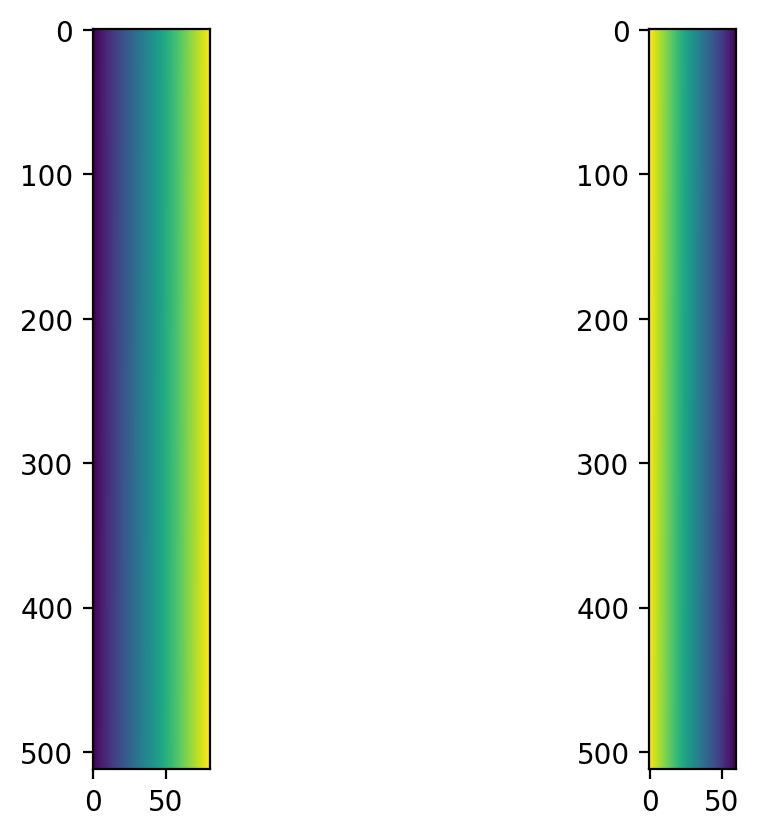

In [172]:
tr_im = augment(img)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(tr_im)
plt.show();

In [179]:
class BasicNet(nn.Module):
    def __init__(self, output_features_size, kernel_size=3):
        super().__init__()
        self.output_features_size = output_features_size
        self.conv_1 = nn.Conv1d(60, output_features_size, kernel_size=kernel_size, padding=1)
        self.conv_2 = nn.Conv1d(output_features_size, output_features_size, kernel_size=kernel_size, padding=1)
        self.mp_1 = nn.MaxPool1d(2, 2)
        self.conv_3 = nn.Conv1d(output_features_size, output_features_size, kernel_size=kernel_size, padding=1)
        self.conv_4 = nn.Conv1d(output_features_size, output_features_size, kernel_size=kernel_size, padding=1)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        plt.imshow(x[0].detach().numpy())
        x = F.relu(self.conv_2(x))
        x = self.mp_1(x)
        x = F.relu(self.conv_3(x))
        x = self.conv_4(x).mean(axis = 2)
        return x

In [183]:
bn = BasicNet(512,3)

torch.Size([64, 512])

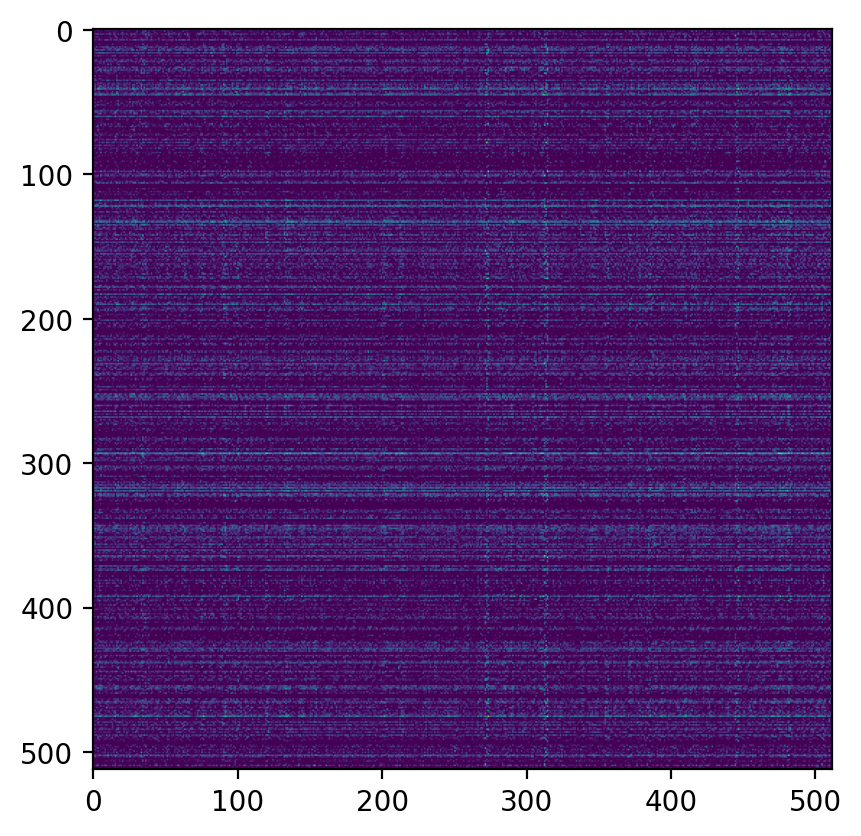

In [184]:
bn(timgs.transpose(2,1)).shape

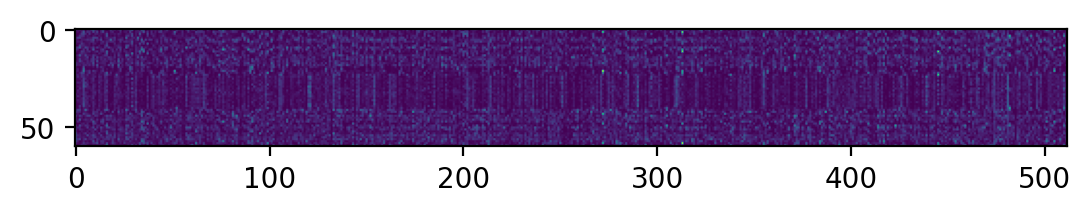

In [185]:
plt.imshow(timgs.transpose(2,1).detach().numpy()[0])

## Model

In [307]:
initializer = tf.keras.initializers.Constant(1.0)
values = initializer(shape=(kernel_size, kernel_size))

In [308]:
img = np.stack(
    [
        np.full(20, 1),
        np.full(20, 2),
        np.full(20, 3),
        np.full(20, 4),
        np.full(20, 5),
        np.full(20, 6),
        np.full(20, 7),
        np.full(20, 8),
        np.full(20, 9),
        np.full(20, 10),
        np.full(20, 11),
        np.full(20, 12),
    ]
)
img = np.expand_dims(img, [0, -1]).astype("float32")
img.shape

(1, 12, 20, 1)

In [309]:
input_shape = img.shape[1:]
kernel_size = 5
dropout_rate = 0.1
embedding_len = 1024
activation_fn = "relu"
padding = "valid"
dense_activation = "relu"
filters = 2

In [334]:
img.shape
img1 = keras.layers.Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation=activation_fn,
    input_shape=img.shape,
    padding=padding,
    kernel_initializer=initializer,
)(img)
img1 = keras.layers.Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation=activation_fn,
    input_shape=img.shape,
    padding=padding,
    kernel_initializer=initializer,
)(img1)
img1 = keras.layers.Conv1D(
    filters=filters,
    kernel_size=kernel_size,
    activation=activation_fn,
    input_shape=img.shape,
    padding=padding,
    kernel_initializer=initializer,
)(img1)
img1.shape

(1, 12, 20, 1)

TensorShape([1, 12, 8, 2])

In [335]:
img2 = keras.layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    activation=activation_fn,
    input_shape=img.shape,
    padding=padding,
    # kernel_initializer=initializer,
)(img)
img2 = keras.layers.Conv2D(
    filters=filters,
    kernel_size=kernel_size,
    activation=activation_fn,
    input_shape=img.shape,
    padding=padding,
    # kernel_initializer=initializer,
)(img2)
img2.shape

TensorShape([1, 4, 12, 2])

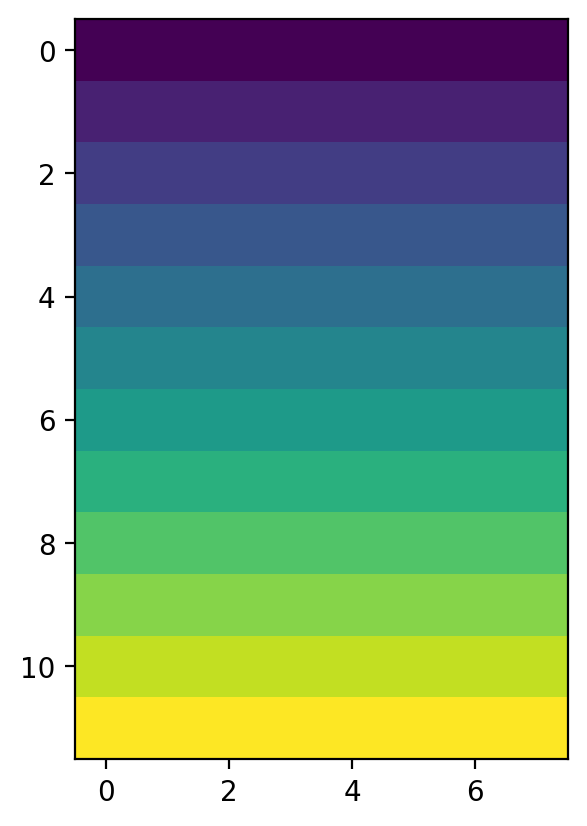

In [336]:
plt.imshow(img1.numpy()[0, :, :, 0])

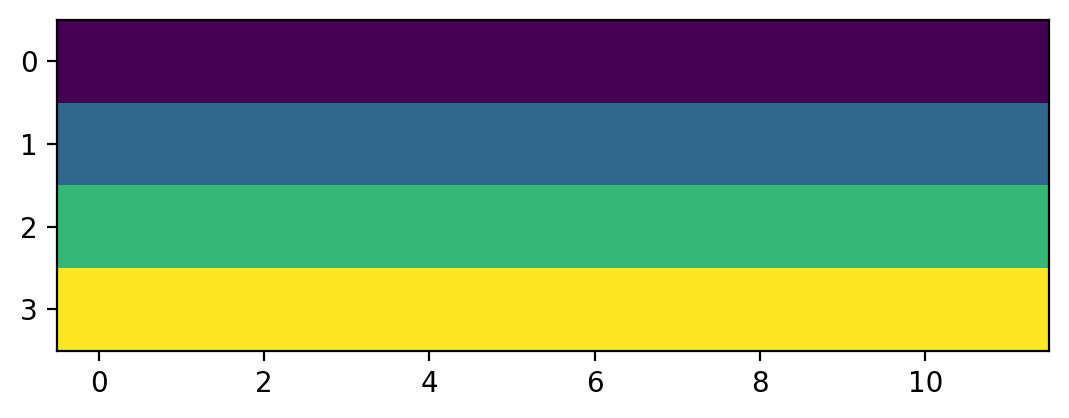

In [337]:
plt.imshow(img2.numpy()[0, :, :, 0])

In [338]:
img1

<tf.Tensor: shape=(1, 12, 8, 2), dtype=float32, numpy=
array([[[[ 500.,  500.],
         [ 500.,  500.],
         [ 500.,  500.],
         [ 500.,  500.],
         [ 500.,  500.],
         [ 500.,  500.],
         [ 500.,  500.],
         [ 500.,  500.]],

        [[1000., 1000.],
         [1000., 1000.],
         [1000., 1000.],
         [1000., 1000.],
         [1000., 1000.],
         [1000., 1000.],
         [1000., 1000.],
         [1000., 1000.]],

        [[1500., 1500.],
         [1500., 1500.],
         [1500., 1500.],
         [1500., 1500.],
         [1500., 1500.],
         [1500., 1500.],
         [1500., 1500.],
         [1500., 1500.]],

        [[2000., 2000.],
         [2000., 2000.],
         [2000., 2000.],
         [2000., 2000.],
         [2000., 2000.],
         [2000., 2000.],
         [2000., 2000.],
         [2000., 2000.]],

        [[2500., 2500.],
         [2500., 2500.],
         [2500., 2500.],
         [2500., 2500.],
         [2500., 2500.],
         [25

In [333]:
img2

<tf.Tensor: shape=(1, 4, 12, 2), dtype=float32, numpy=
array([[[[0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974],
         [0.       , 2.0714974]],

        [[0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796],
         [0.       , 2.6218796]],

        [[0.       , 3.1722624],
         [0.       , 3.1722624],
         [0.       , 3.1722624],
         [0.       , 3.1722624],
         [0.     

In [30]:
def embNet(
    input_shape,
    kernel_size=3,
    dropout_rate=0.1,
    embedding_len=1024,
    activation_fn="relu",
    padding="valid",
    dense_activation="relu",
):
    base_model = tf.keras.models.Sequential(
        [
            keras.layers.Conv1D(
                filters=2,
                kernel_size=kernel_size,
                activation=activation_fn,
                input_shape=input_shape,
                padding=padding,
                name="conv_1",
            ),
            keras.layers.Conv1D(
                filters=4,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_2",
            ),
            keras.layers.Dropout(rate=dropout_rate),
            keras.layers.MaxPooling2D(
                pool_size=(4, 2), strides=1, padding=padding, name="max_1"
            ),
            keras.layers.Conv2D(
                filters=8,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_3",
            ),
            keras.layers.Conv1D(
                filters=16,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_4",
            ),
            keras.layers.Dropout(rate=dropout_rate),
            keras.layers.MaxPooling2D(
                pool_size=(4, 2), strides=1, padding=padding, name="max_2"
            ),
            keras.layers.Conv1D(
                filters=32,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_5",
            ),
            keras.layers.Conv1D(
                filters=64,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
                name="conv_6",
            ),
            keras.layers.Dropout(rate=dropout_rate),
            keras.layers.MaxPooling2D(
                pool_size=(4, 2), strides=1, padding=padding, name="max_3"
            ),
            keras.layers.Flatten(name="flatten"),
            keras.layers.Dense(
                embedding_len, activation=dense_activation, name="dense_1"
            ),
        ]
    )

    x = keras.layers.Reshape((1, -1))(base_model.output)
    embedding_net = keras.Model(inputs=base_model.input, outputs=x, name="embedding")
    return embedding_net

In [31]:
embedding_net = embNet(
    input_shape=cfg.input_shape,
    kernel_size=7,
    dropout_rate=0.1,
    embedding_len=cfg.emb_len,
    activation_fn="relu",
    padding="valid",
    dense_activation="relu",
)

In [32]:
embedding_net.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1_input (InputLayer)   [(None, 512, 60, 1)]      0         
                                                                 
 conv_1 (Conv1D)             (None, 512, 54, 2)        16        
                                                                 
 conv_2 (Conv1D)             (None, 512, 48, 4)        60        
                                                                 
 dropout_3 (Dropout)         (None, 512, 48, 4)        0         
                                                                 
 max_1 (MaxPooling2D)        (None, 509, 47, 4)        0         
                                                                 
 conv_3 (Conv2D)             (None, 503, 41, 8)        1576      
                                                                 
 conv_4 (Conv1D)             (None, 503, 35, 16)       91

In [72]:
def low_res_models(
    kernel_size=(9, 9),
    activation_fn="relu",
    padding="valid",
    input_shape=cfg.input_shape,
    n_filters=4,
    pool_size=7,
    embedding_len=1024,
):
    low_res_1 = tf.keras.models.Sequential(
        [
            tf.keras.layers.Resizing(
                height=60,
                width=60,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
                input_shape=input_shape,
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
            ),
            keras.layers.MaxPooling2D(pool_size=pool_size, strides=1, padding=padding),
            keras.layers.Flatten(),
            keras.layers.Dense(embedding_len, activation=activation_fn),
        ],
        name="low_res_1",
    )
    low_res_2 = tf.keras.models.Sequential(
        [
            tf.keras.layers.Resizing(
                height=30,
                width=30,
                interpolation="bilinear",
                crop_to_aspect_ratio=False,
                input_shape=input_shape,
            ),
            keras.layers.BatchNormalization(),
            keras.layers.Conv2D(
                filters=n_filters,
                kernel_size=kernel_size,
                activation=activation_fn,
                padding=padding,
            ),
            keras.layers.MaxPooling2D(pool_size=pool_size, strides=1, padding=padding),
            keras.layers.Flatten(),
            keras.layers.Dense(embedding_len, activation=activation_fn),
        ],
        name="low_res_2",
    )
    return low_res_1, low_res_2

In [73]:
low_res_1, low_res_2 = low_res_models(
    kernel_size=(9, 9),
    activation_fn="relu",
    padding="valid",
    input_shape=cfg.input_shape,
    n_filters=4,
    pool_size=7,
    embedding_len=1024,
)

In [74]:
low_res_1.summary()

Model: "low_res_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_34 (Resizing)      (None, 60, 60, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 60, 60, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d_34 (Conv2D)          (None, 52, 52, 4)         328       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 46, 46, 4)        0         
 g2D)                                                            
                                                                 
 flatten_22 (Flatten)        (None, 8464)              0         
                                                                 
 dense_20 (Dense)            (None, 1024)              86

In [75]:
low_res_2.summary()

Model: "low_res_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_35 (Resizing)      (None, 30, 30, 1)         0         
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 1)        4         
 hNormalization)                                                 
                                                                 
 conv2d_35 (Conv2D)          (None, 22, 22, 4)         328       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 4)        0         
 g2D)                                                            
                                                                 
 flatten_23 (Flatten)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 1024)              10

In [17]:
embedding_net.output_shape

(None, 370832)

In [16]:
def siamese_model(input_shape, embedding_net, low_res_1, low_res2):
    input_anchor = keras.layers.Input(shape=input_shape, name="anchor")
    input_positive = keras.layers.Input(shape=input_shape, name="positive")
    input_negative = keras.layers.Input(shape=input_shape, name="negative")

    embedding_anchor = embedding_net(input_anchor)
    embedding_positive = embedding_net(input_positive)
    embedding_negative = embedding_net(input_negative)

    output = tf.keras.layers.concatenate(
        [embedding_anchor, embedding_positive, embedding_negative], axis=1
    )

    siamese_net = tf.keras.models.Model(
        [input_anchor, input_positive, input_negative], output, name="siamese"
    )
    return siamese_net

In [17]:
siamese_net = siamese_model(input_shape=cfg.input_shape, embedding_net=embedding_net)

In [18]:
siamese_net.output_shape

(None, 3, 1024)

In [19]:
def triplet_loss(margin=0.5):
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
        negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
        return tf.maximum(positive_dist - negative_dist + margin, 0.0)

    return loss

In [20]:
callbacks = make_callbacks(
    path=mod_dir, monitor="val_loss", mode="min", reduce_patience=10, stop_patience=100
)

In [21]:
siamese_net.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss=triplet_loss())

In [22]:
keras.mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3090, compute capability 8.6


In [23]:
history = siamese_net.fit(
    x=train_gen,
    steps_per_epoch=train_gen.__len__(),
    validation_data=val_gen,
    callbacks=callbacks,
    epochs=cfg.n_epochs,
    use_multiprocessing=True,
    workers=10,
)

Epoch 1/60
2179/2179 [==============================] - ETA: 0s - loss: 0.3104
Epoch 1: val_loss improved from inf to 0.21717, saving model to /app/_data/artist_data/models/test_arch/tripl_4/model.h5
2179/2179 [==============================] - 321s 142ms/step - loss: 0.3104 - val_loss: 0.2172 - lr: 0.0010
Epoch 2/60
2179/2179 [==============================] - ETA: 0s - loss: 0.1733
Epoch 2: val_loss improved from 0.21717 to 0.15887, saving model to /app/_data/artist_data/models/test_arch/tripl_4/model.h5
2179/2179 [==============================] - 309s 141ms/step - loss: 0.1733 - val_loss: 0.1589 - lr: 0.0010
Epoch 3/60
2179/2179 [==============================] - ETA: 0s - loss: 0.1423
Epoch 3: val_loss improved from 0.15887 to 0.14539, saving model to /app/_data/artist_data/models/test_arch/tripl_4/model.h5
2179/2179 [==============================] - 308s 141ms/step - loss: 0.1423 - val_loss: 0.1454 - lr: 0.0010
Epoch 4/60
2179/2179 [==============================] - ETA: 0s - lo

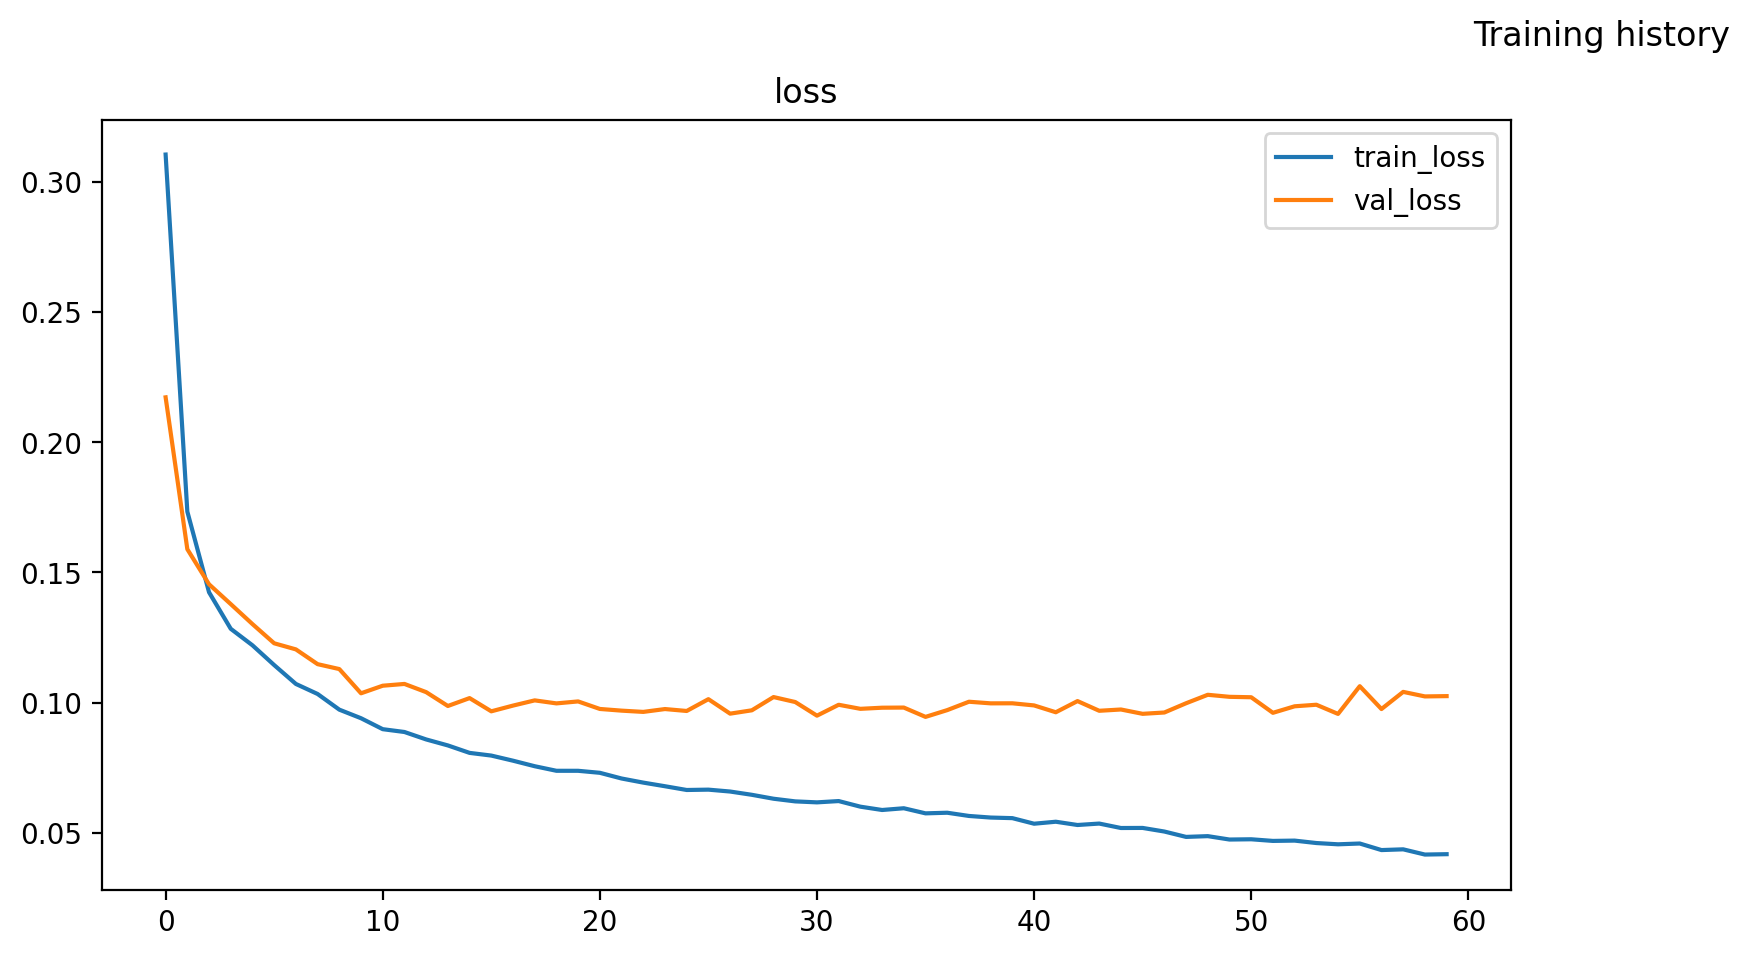

In [24]:
plot_history(history.history)

In [25]:
def save_params(mod_dir, model, history, cfg, loss="constr"):
    train_history = history.history
    min_val_loss = np.min(train_history["val_loss"])

    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{min_val_loss}.h5"),
    )
    config = {
        "loss": loss,
        "history": train_history,
        "norm": cfg.norm,
        "fold": cfg.fold,
        "model": {
            "eff": False,
            "input_shape": cfg.input_shape,
            "embedding_len": cfg.emb_len,
            "kernel_size": cfg.kernel_size,
            "activation_fn": cfg.act_fn,
            "batch_norm": False,
        },
    }
    with open(os.path.join(mod_dir, "config.json"), "w") as f:
        json.dump(config, f)
    model.save(os.path.join(mod_dir, f"model_{min_val_loss}"), include_optimizer=False)
    print(
        f'min_val_loss = {min_val_loss}, model saved to {os.path.join(mod_dir, f"model_{min_val_loss}")}'
    )

In [26]:
save_params(mod_dir, siamese_net, history, cfg, loss="tripl")

INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/tripl_4/model_0.09447911381721497/assets


INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/tripl_4/model_0.09447911381721497/assets


min_val_loss = 0.09447911381721497, model saved to /app/_data/artist_data/models/test_arch/tripl_4/model_0.09447911381721497


In [27]:
[x.name for x in siamese_net.layers]

['anchor', 'positive', 'negative', 'embedding', 'concatenate']

In [28]:
# siamese_net(imgs[:3]).get_output('embedding')

In [29]:
embedding_net.set_weights(siamese_net.weights)

In [30]:
val_df

trackid  artistid archive_features_path  \
0       105739         4      4/9/3/105739.npy   
1            4         4           4/4/0/4.npy   
2          868         4         4/8/6/868.npy   
3        16333         4       4/3/3/16333.npy   
4        68038         4       4/8/3/68038.npy   
...        ...       ...                   ...   
27699   153876     18455      5/6/7/153876.npy   
27700   151291     18461      1/1/9/151291.npy   
27701   155004     18461      1/4/0/155004.npy   
27702   161032     18467      7/2/3/161032.npy   
27703   166713     18467      7/3/1/166713.npy   

                                                    path       max  min  \
0      /app/_data/artist_data/train_features/4/9/3/10...  4.224643  0.0   
1      /app/_data/artist_data/train_features/4/4/0/4.npy  3.786215  0.0   
2      /app/_data/artist_data/train_features/4/8/6/86...  3.098363  0.0   
3      /app/_data/artist_data/train_features/4/3/3/16...  5.220033  0.0   
4      /app/_data/artist_data/train_features/4/8/3/68...  4.476882  0.0   
...                                                  ...       ...  ...   
27699  /app/_data/artist_data/train_features/5/6/7/15...  5.924749  0.0   
27700  /app/_data/artist_data/train_features/1/1/9/15...  4.962697  0.0   
27701  /app/_data/artist_data/train_features/1/4/0/15...  5.474594  0.0   
27702  /app/_data/artist_data/train_features/7/2/3/16...  6.289591  0.0   
27703  /app/_data/artist_data/train_features/7/3/1/16...  4.223980  0.0   

           mean  width  height  artistid_count  fold  
0      0.444227   81.0   512.0              10   2.0  
1      0.444095   81.0   512.0              10   2.0  
2      0.370418   81.0   512.0              10   2.0  
3      0.367171   73.0   512.0              10   2.0  
4      0.419996   81.0   512.0              10   2.0  
...         ...    ...     ...             ...   ...  
27699  0.441504   81.0   512.0               2   2.0  
27700  0.382900   81.0   512.0               2   2.0  
27701  0.382723   81.0   512.0               2   2.0  
27702  0.315962   81.0   512.0               2   2.0  
27703  0.439307   81.0   512.0               2   2.0  

[27704 rows x 11 columns]

In [31]:
class TestGenerator(keras.utils.Sequence):
    def __init__(
        self,
        data,
        img_size,
        batch_size=32,
        norm=False,
        n_chanels=1,
    ):
        self.data = data.reset_index(drop=True)
        self.img_size = img_size
        self.batch_size = batch_size
        self.norm = norm
        self.n_chanels = n_chanels
        self.default_img_size = (512, 81)

    def __len__(self):
        return self.data.shape[0] // self.batch_size

    def load_img(self, path):
        img = np.load(path).astype("float32")
        if self.norm:
            img -= img.min()
            img /= img.max()
        if self.img_size < self.default_img_size:
            wpad = (img.shape[1] - self.img_size[1]) // 2
            img = img[:, wpad : wpad + self.img_size[1]]
        if img.shape != self.img_size:
            wpad = self.img_size[1] - img.shape[1]
            wpad_l = wpad // 2
            wpad_r = wpad - wpad_l
            img = np.pad(
                img,
                pad_width=((0, 0), (wpad_l, wpad_r)),
                mode="constant",
                constant_values=0,
            )
        img = np.expand_dims(img, -1)
        if self.n_chanels == 3:
            img = np.concatenate([img, img, img], -1)
        return img

    def __getitem__(self, batch_ix):
        imgs = np.zeros([self.batch_size, *self.img_size, self.n_chanels])

        for i in range(self.batch_size):
            ix = i + self.batch_size * batch_ix
            img = self.load_img(self.data.loc[ix, "path"])
            imgs[i] = img

        return imgs

In [32]:
def pairwise_distances(array):
    dists = tf.add(
        tf.reduce_sum(tf.square(array), axis=[1], keepdims=True),
        tf.reduce_sum(tf.square(tf.transpose(array)), axis=[0], keepdims=True),
    ) - 2.0 * tf.matmul(array, tf.transpose(array))
    return dists

In [33]:
def choose_100(
    prediction,
    df,
):
    dists = pairwise_distances(prediction)
    neigh = {}
    for ix in tqdm(range(dists.shape[0])):
        trackid = df.loc[ix, "trackid"]
        nearest_100 = np.argsort(dists[ix])[:101]
        tracks_100 = df.loc[nearest_100, "trackid"].tolist()
        neigh[trackid] = {
            "tracks": [x for x in tracks_100 if x != trackid],
            "atrtistid": df.loc[ix, "artistid"],
            "artists": df.loc[nearest_100, "artistid"].tolist(),
        }

    return neigh

In [34]:
test_gen = TestGenerator(
    data=val_df,
    img_size=cfg.img_size,
    batch_size=1,
    norm=False,
    n_chanels=1,
)

In [35]:
pred_val = np.squeeze(embedding_net.predict(test_gen))

27704/27704 [==============================] - 162s 6ms/step


In [36]:
neigh = choose_100(pred_val, val_df)

100% 27704/27704 [01:30<00:00, 307.25it/s]


In [37]:
dists = pairwise_distances(pred_val)

<AxesSubplot:>

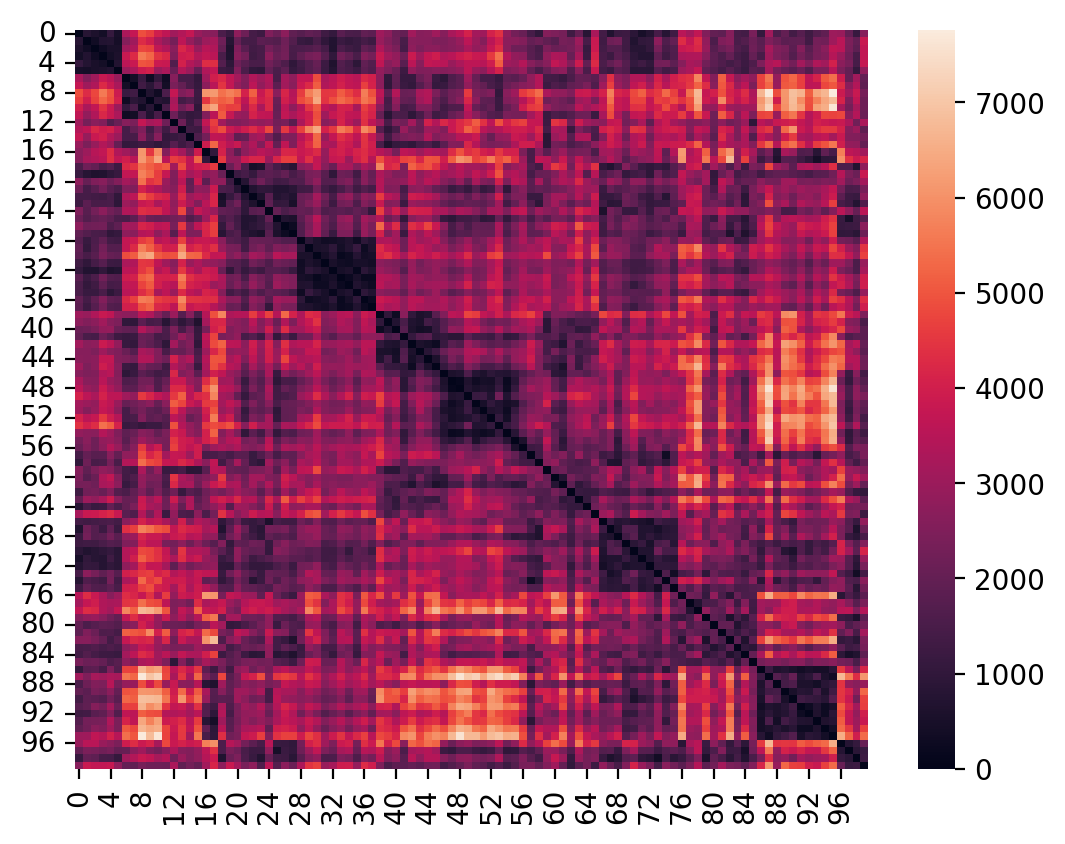

In [38]:
sns.heatmap(pairwise_distances(pred_val[900:1000]))

In [39]:
l = []
for k in neigh.keys():
    l.append(len([1 for x in neigh[k]["artists"] if x == neigh[k]["atrtistid"]]))

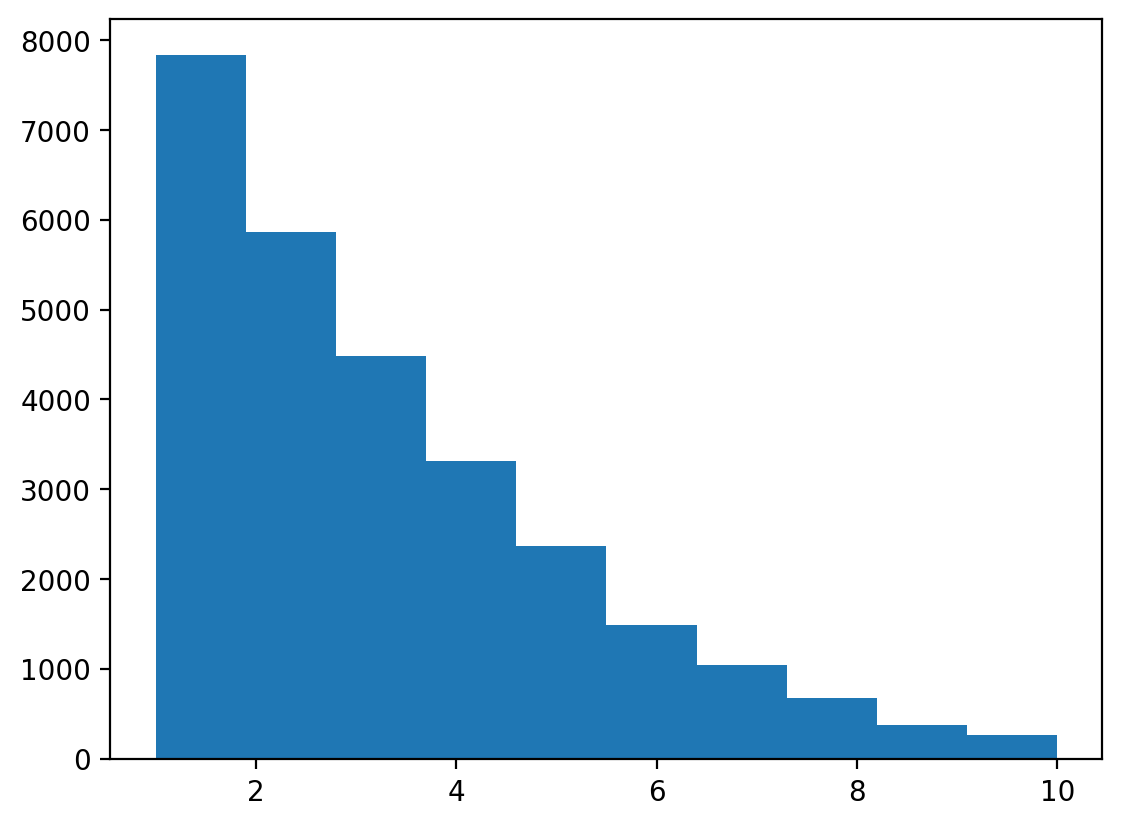

In [40]:
plt.hist(l)
plt.show();

In [41]:
def position_discounter(position):
    return 1.0 / np.log2(position + 1)


def get_ideal_dcg(relevant_items_count, top_size):
    dcg = 0.0
    for result_indx in range(min(top_size, relevant_items_count)):
        position = result_indx + 1
        dcg += position_discounter(position)
    return dcg


def compute_dcg(query_trackid, ranked_list, track2artist_map):
    query_artistid = track2artist_map[query_trackid]
    dcg = 0.0
    for result_indx, result_trackid in enumerate(ranked_list):
        position = result_indx + 1
        discounted_position = position_discounter(position)
        result_artistid = track2artist_map[result_trackid]
        if result_artistid == query_artistid:
            dcg += discounted_position
    return dcg

In [42]:
def eval_submission(tracks_meta, submission, top_size=100):
    track2artist_map = tracks_meta.set_index("trackid")["artistid"].to_dict()
    track2subset_map = tracks_meta.set_index("trackid")["subset"].to_dict()
    artist2tracks_map = tracks_meta.groupby("artistid").agg(list)["trackid"].to_dict()

    ndcg_list = defaultdict(list)
    for _, row in tracks_meta.iterrows():
        query_trackid = row["trackid"]
        ranked_list = submission[query_trackid]["tracks"]
        query_artistid = track2artist_map[query_trackid]
        query_artist_tracks_count = len(artist2tracks_map[query_artistid])
        ideal_dcg = get_ideal_dcg(query_artist_tracks_count - 1, top_size=top_size)
        dcg = compute_dcg(query_trackid, ranked_list, track2artist_map)
        if ideal_dcg != 0:
            ndcg_list[track2subset_map[query_trackid]].append(dcg / ideal_dcg)

    result = {}
    for subset, values in ndcg_list.items():
        result[subset] = np.mean(values)
    return result

In [43]:
val_df["subset"] = "0"
from collections import defaultdict

In [44]:
r = eval_submission(val_df, neigh)

In [45]:
r

{'0': 0.1410507742300167}